In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
dataset = pd.read_csv('train.csv')

In [5]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
x_train = dataset.iloc[:,1:-1]

In [7]:
y = dataset.iloc[:,-1].values

In [8]:
def differentiate_features(x_train):
    discrete_features = []
    continuous_features = []
    for i,j in zip(x_train,x_train.dtypes):
        if j.type==np.int64 or j.type==np.float64:
            continuous_features.append(i)
        else:
            discrete_features.append(i)
    return discrete_features,continuous_features

In [9]:
discrete_features,continuous_features = differentiate_features(x_train)

In [10]:
def get_imputer(x_continuous):
    imputer = Imputer(missing_values = np.nan, strategy = 'mean', axis = 0)
    imputer.fit(x_continuous)
    return imputer

In [11]:
x_continuous = dataset.filter(continuous_features).values
imputer = get_imputer(x_continuous)

c:\users\sappusamy\appdata\local\continuum\anaconda3\envs\sri\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
def get_data_from_imputer(imputer,x_continuous):
    x_continuous = imputer.transform(x_continuous)
    return x_continuous

In [13]:
x_continuous = get_data_from_imputer(imputer,x_continuous)

In [14]:
x_continuous.shape

(1460, 36)

In [15]:
def get_label_encoder(discrete_features,x_discrete):
    label_encoder_dict={}
    for col in discrete_features:
        label_encoder_dict[col] = LabelEncoder()
        x_discrete[col] = x_discrete[col].fillna('')
        s = x_discrete[col].astype(str).unique()
        if '' not in s: s = np.append(s,[''])
        label_encoder_dict[col].fit(s)
    return label_encoder_dict

In [16]:
x_discrete = dataset.filter(discrete_features)

In [17]:
label_encoder_dict = get_label_encoder(discrete_features,x_discrete)

In [18]:
def get_discrete_encoder(label_encoder_dict,x_discrete):
    for col in label_encoder_dict:
        x_discrete[col] = label_encoder_dict[col].transform(x_discrete[col])
    return x_discrete

In [19]:
x_discrete = get_discrete_encoder(label_encoder_dict,x_discrete)

In [20]:
try:
    n_discrete = x_discrete.shape[1]
except:
    n_discrete = 0
n_discrete

43

In [21]:
def generate_onehot_encoder(n_discrete):
    onehotencoder = OneHotEncoder(categorical_features = list(range(n_discrete)))
    onehotencoder.fit(x_discrete)
    return onehotencoder

In [22]:
onehotencoder = generate_onehot_encoder(n_discrete)

c:\users\sappusamy\appdata\local\continuum\anaconda3\envs\sri\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [23]:
def get_onehot_encoder(onehotencoder,x_continuous,x_discrete):
    x_discrete = onehotencoder.transform(x_discrete).toarray()
    x = np.concatenate([x_continuous,x_discrete],axis=1)
    x = np.concatenate([np.ones((len(x),1)),x],axis=1)
    return x

In [24]:
x = get_onehot_encoder(onehotencoder,x_continuous,x_discrete)

In [25]:
def get_standardscaler(x,y):
    sc_X = StandardScaler()
    sc_X.fit(x)
    sc_y = StandardScaler()
    sc_y.fit(y.reshape(-1,1))
    return sc_X,sc_y

In [26]:
sc_X,sc_Y = get_standardscaler(x,y)

In [27]:
def get_normalized(sc_X,sc_Y,x,y):
    x = sc_X.transform(x)
    y = sc_Y.transform(y.reshape(-1,1))
    return x,y.reshape(-1)

In [28]:
x_train,y_train = get_normalized(sc_X,sc_Y,x,y)

In [29]:
num_features = x.shape[1]
num_features

305

In [30]:
# mean square error
def mse(preds,actual):
    return ((preds-actual)**2).sum()/(2*len(preds))

In [31]:
def derivative_w(y,y_train,x):
    dw = np.matmul((y-y_train),x)/len(x)
    return dw

In [32]:
epochs = 100
w = np.random.random((num_features))
lr = 1e-1

In [33]:
loss=0
for epoch in range(epochs):
    pred_y = np.matmul(x_train,w)
    loss = mse(pred_y,y_train)
    print('Epoch ',epoch,':-',loss)
    dw = derivative_w(pred_y,y_train,x_train)
    w = w - lr*dw

Epoch  0 :- 51.91264328654337
Epoch  1 :- 21.219822573619997
Epoch  2 :- 13.822265588711415
Epoch  3 :- 10.298879847415712
Epoch  4 :- 8.072724837515603
Epoch  5 :- 6.50859851229243
Epoch  6 :- 5.349501408090067
Epoch  7 :- 4.461425451399752
Epoch  8 :- 3.764831418192184
Epoch  9 :- 3.208640306724622
Epoch  10 :- 2.758238795849928
Epoch  11 :- 2.3892361752756806
Epoch  12 :- 2.083925983256532
Epoch  13 :- 1.829148716792564
Epoch  14 :- 1.6149357197354797
Epoch  15 :- 1.433614504999208
Epoch  16 :- 1.2791995680239319
Epoch  17 :- 1.1469666570973376
Epoch  18 :- 1.033148698639995
Epoch  19 :- 0.9347145517966347
Epoch  20 :- 0.8492054338296129
Epoch  21 :- 0.7746122775768458
Epoch  22 :- 0.7092826288944335
Epoch  23 :- 0.651849177470491
Epoch  24 :- 0.6011743388666435
Epoch  25 :- 0.5563068868659519
Epoch  26 :- 0.5164477296764571
Epoch  27 :- 0.48092269281853767
Epoch  28 :- 0.44916071970163435
Epoch  29 :- 0.42067629638714726
Epoch  30 :- 0.3950551956085357
Epoch  31 :- 0.37194284788052

In [34]:
x_train.shape

(1460, 305)

In [35]:
def get_normalized_test_data(x_test,
                             y_test,
                             continuous_features,
                             discrete_features,
                             imputer,
                             label_encoder_dict,
                             onehotencoder,
                             sc_X,
                             sc_Y
                            ):
    x_test_continuous = x_test.filter(continuous_features)
    x_test_discrete = x_test.filter(discrete_features)
    
    x_test_continuous = get_data_from_imputer(imputer,x_test_continuous)
    
    x_test_discrete = x_test_discrete.fillna('')
    
    x_test_discrete = get_discrete_encoder(label_encoder_dict,x_test_discrete)
    
    x = get_onehot_encoder(onehotencoder,x_test_continuous,x_test_discrete)
    
    x_test,y_test = get_normalized(sc_X,sc_Y,x,y_test)
    
    return x_test,y_test
    

In [36]:
x_test = pd.read_csv('test.csv')

In [37]:
y_test = pd.read_csv('sample_submission.csv')

In [38]:
y_test = y_test['SalePrice'].to_numpy()

In [39]:
x_test, y_test = get_normalized_test_data(x_test,
                             y_test,
                             continuous_features,
                             discrete_features,
                             imputer,
                             label_encoder_dict,
                             onehotencoder,
                             sc_X,
                             sc_Y
                            )

In [40]:
pred_y = np.matmul(x_test,w)

In [41]:
mse(pred_y,y_test)

1.0419742616912262

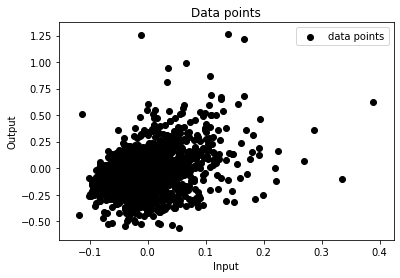

In [42]:
# plot of test data points
plt.scatter(x_test.mean(1),y_test,color='k',label='data points')
# plt.plot(x_test.mean(1),pred_y,'r',label='test',linewidth=2)

plt.title('Data points')
plt.xlabel('Input')
plt.ylabel('Output')

plt.legend()

plt.grid(False)

plt.show()

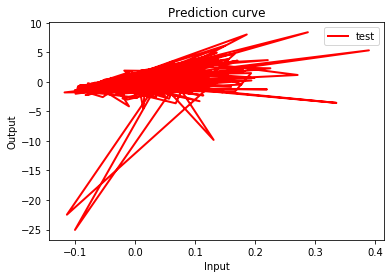

In [43]:
# plot of test data points
# plt.scatter(x_test.mean(1),y_test,color='k',label='data points')
plt.plot(x_test.mean(1),pred_y,'r',label='test',linewidth=2)

plt.title('Prediction curve')
plt.xlabel('Input')
plt.ylabel('Output')

plt.legend()

plt.grid(False)

plt.show()

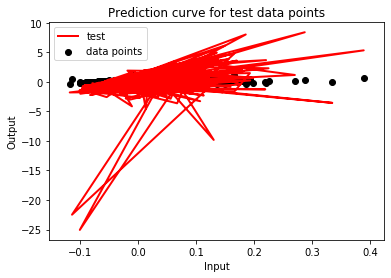

In [44]:
# plot of test data points
plt.scatter(x_test.mean(1),y_test,color='k',label='data points')
plt.plot(x_test.mean(1),pred_y,'r',label='test',linewidth=2)

plt.title('Prediction curve for test data points')
plt.xlabel('Input')
plt.ylabel('Output')

plt.legend()

plt.grid(False)

plt.show()